In [1]:
import h5py
import os
import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from collections.abc import Iterable
import pandas as pd
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader
import timm
from torchvision.models import swin_s

random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device=("cuda" if torch.cuda.is_available() else "cpu")
torch.device(device)
print(device)

cuda


In [2]:
batch_size=384
img_size=128

In [3]:
train_dir='/kaggle/input/isic-2024-challenge/train-metadata.csv'
train_images='/kaggle/input/isic-2024-challenge/train-image/image'

In [4]:
def open_image(images,key):
    f=h5py.File(images,'r')
    image_data=f[key][()]
    nparr = np.frombuffer(image_data, np.uint8)
    img=cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img

In [5]:
df=pd.read_csv(train_dir,usecols=['isic_id','target'])
df.head()

,isic_id,target
0,ISIC_0015670,0
1,ISIC_0015845,0
2,ISIC_0015864,0
3,ISIC_0015902,0
4,ISIC_0024200,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   isic_id  401059 non-null  object
 1   target   401059 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [7]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(df['isic_id'],df['target'],test_size=0.2,random_state=42)
train=pd.concat([x_train,y_train],axis=1)
valid=pd.concat([x_valid,y_valid],axis=1)
train.head()

,isic_id,target
18085,ISIC_0517312,0
171181,ISIC_4318651,0
284095,ISIC_7110993,0
354900,ISIC_8861121,0
77679,ISIC_1994958,0


In [8]:
neg=train[train['target']==0]
pos=train[train['target']==1]

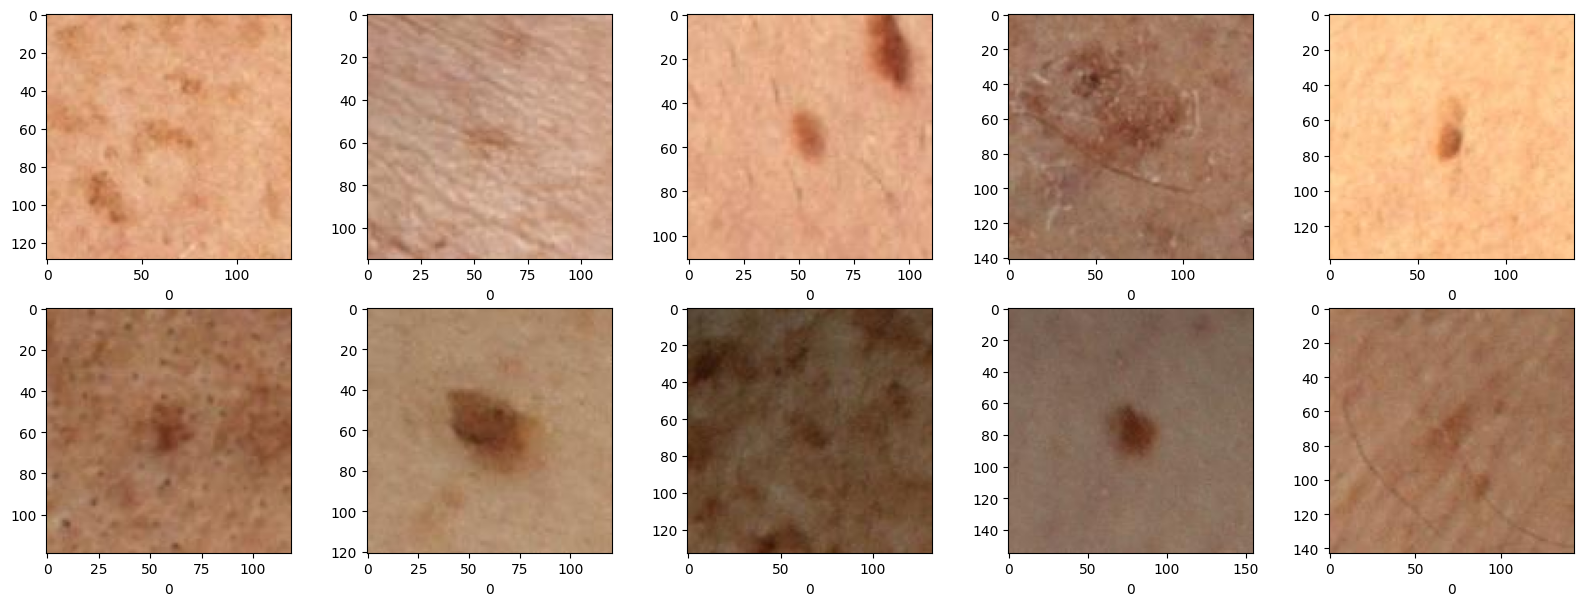

In [9]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    key=neg.loc[neg.index.values[i],'isic_id']
    img=cv2.imread(f'{train_images}/{key}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].set_xlabel(neg.loc[neg.index.values[i],'target'])

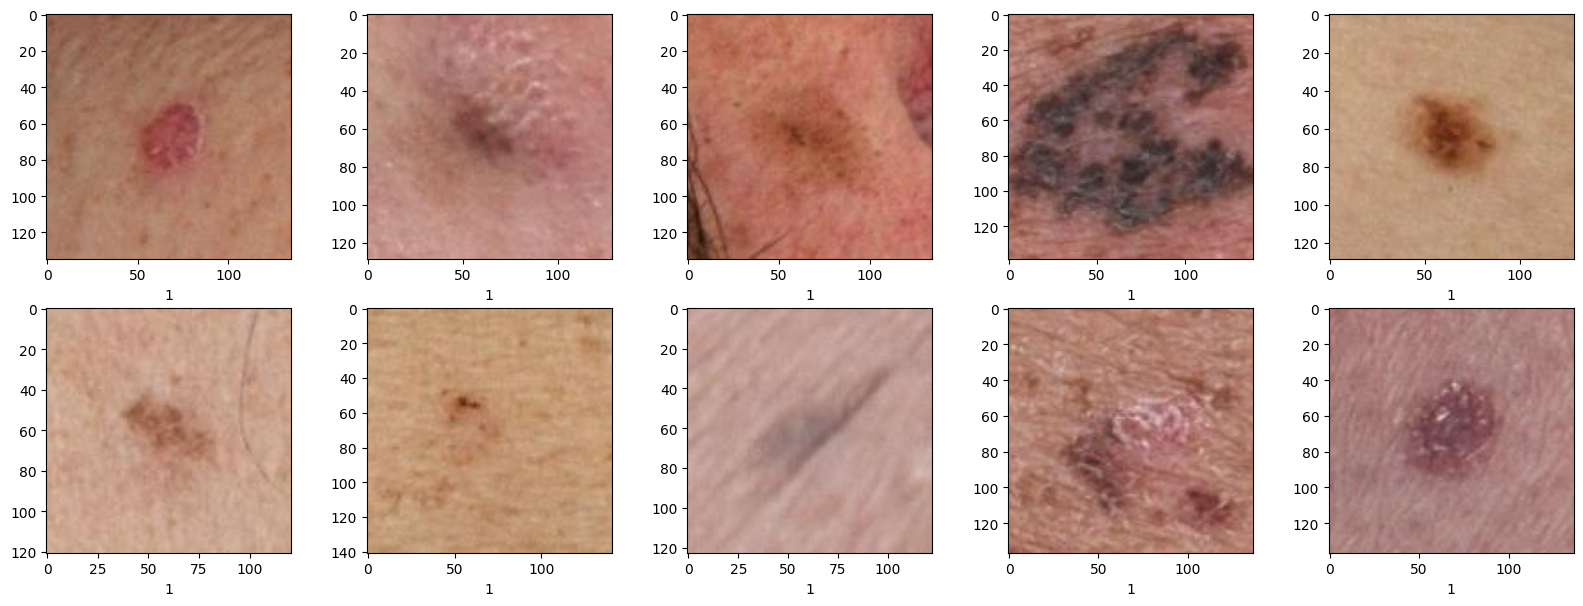

In [10]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    key=pos.loc[pos.index.values[i],'isic_id']
    img=cv2.imread(f'{train_images}/{key}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].set_xlabel(pos.loc[pos.index.values[i],'target'])

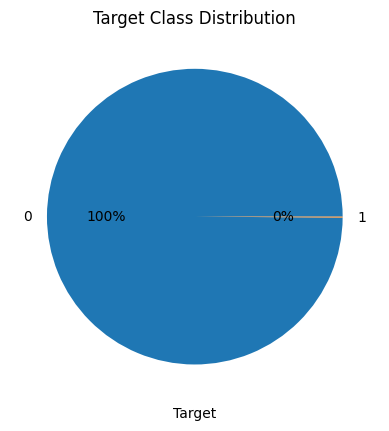

In [11]:
unique,count=np.unique(y_train,return_counts=True)
plt.pie(x=count,labels=unique,autopct='%.0f%%')
plt.xlabel('Target')
plt.title('Target Class Distribution')
plt.show()

In [12]:
def get_transforms(image_size):

    transforms_train = v2.Compose([
        v2.RandomVerticalFlip(p=0.5),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2,contrast=0.2),
        v2.RandomAffine(translate=(0.1,0.1), 
                        scale=(0.1,0.2), 
                        degrees=15, 
                        interpolation=InterpolationMode.BILINEAR),
        v2.Resize((image_size, image_size),
                  interpolation=InterpolationMode.BILINEAR,
                  antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
    ])

    transforms_val = v2.Compose([
        v2.Resize((image_size, image_size),
                  interpolation=InterpolationMode.BILINEAR,
                  antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
    ])

    return transforms_train, transforms_val

transform_train, transform_val = get_transforms(img_size)

In [13]:
class ISICDataset(Dataset):
    def __init__(self, isic_id, images, targets, transforms, device):
        self.transforms=transforms
        self.isic_id=isic_id
        self.targets=targets
        self.device=device
        self.images=images
        
    
    def __len__(self):
        return len(self.isic_id)
    
    def __preprocess(self,image):
        image=cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        clahe=cv2.createCLAHE(tileGridSize=(8,8),clipLimit=1)
        image[:,:,0]=clahe.apply(image[:,:,0])
        image=cv2.cvtColor(image,cv2.COLOR_LAB2RGB)
        return image
    
    def __getitem__(self, index):
        key=self.isic_id[index]
        if len(self.images.split('.'))>1:
            image=open_image(self.images,key)
        else:
            image=cv2.imread(f'{self.images}/{key}.jpg')
        image=self.__preprocess(image) #one of them
        #image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #one of them
        image=np.moveaxis(image,-1,0)
        image=torch.from_numpy(image)
        if self.transforms:
            image=self.transforms(image)
        try:
            label=torch.tensor(data=self.targets[index])
            return image,label
        except:
            return image

In [14]:
def loading_data(isic_id,images,targets,batch_size,shuffle,transforms,device):
    dataset=ISICDataset(isic_id,images,targets,transforms,device)
    dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,num_workers=4)
    return dataloader

In [15]:
train_loader=loading_data(train['isic_id'].values,
                          train_images,
                          train['target'].values,
                          batch_size,
                          True,
                          transform_train,
                          device)
val_loader=loading_data(valid['isic_id'].values,
                        train_images,
                        valid['target'].values,
                        batch_size,
                        False,
                        transform_val,
                        device)

In [16]:
class SwinViT(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.base=swin_s(weights='DEFAULT')
        self.base.head=torch.nn.Identity()
        self.out=torch.nn.Sequential(
            torch.nn.Linear(768,num_classes),
            torch.nn.Sigmoid()
        )
    def forward(self,inputs):
        cls_token=self.base(inputs)
        return self.out(cls_token)

In [17]:
class Trainer():
    def __init__(self, 
                 model, 
                 loss_fn, 
                 T, 
                 init_lr, 
                 min_lr, 
                 optimizer, 
                 wd) -> None:
        assert optimizer in ['adamw','sgd'], 'Only support SGD or AdamW'
        self.model=model
        opt_choice={'adamw':torch.optim.AdamW(self.model.parameters(),
                                              lr=init_lr,
                                              weight_decay=wd),
                    'sgd':torch.optim.SGD(self.model.parameters(),
                                          lr=init_lr,weight_decay=wd,
                                          momentum=0.9)}
        self.opt=opt_choice[optimizer]
        self.sch=torch.optim.lr_scheduler.CosineAnnealingLR(self.opt,T,min_lr)
        self.loss_fn=loss_fn
        self.history={'losses':[], 
                      'val_losses':[]}
        
    def __trainstep(self,train_loader: DataLoader, verbose: int):
        self.model.train()
        train_loss=0
        batches=len(train_loader)
        if verbose == 1:
            train_loader=tqdm(train_loader)
        for x,y in train_loader:
            x,y=x.to(device),y.to(device)
            pred=self.model(x).squeeze(-1)
            loss=self.loss_fn(pred,y.float())
            if verbose==1:
                train_loader.set_postfix({'loss':loss.item()})
            train_loss+=loss.item()
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        train_loss/=batches
        train_loader.set_description(desc=f'Mean Training Loss: {train_loss}')
        self.history['losses'].append(train_loss)

    def __evalstep(self, val_loader: DataLoader,verbose: int):
        self.model.eval()
        val_loss=0
        batches=len(val_loader)
        if verbose == 1:
            val_loader=tqdm(val_loader)
        with torch.no_grad():
            for x,y in val_loader:
                x,y=x.to(device),y.to(device)
                pred=self.model(x).squeeze(-1)
                loss=self.loss_fn(pred,y.float())
                if verbose==1:
                    val_loader.set_postfix({'loss':loss.item()})
                val_loss+=loss.item()
        val_loss/=batches
        val_loader.set_description(desc=f'Mean Validation Loss: {val_loss}')
        self.history['val_losses'].append(val_loss)

    def fit(self, train_loader: DataLoader, 
            val_loader: DataLoader, 
            epochs: int, 
            verbose: int, 
            patience: int):
        assert verbose in [0,1], 'verbose must be either 0 or 1'
        best_loss = float('inf')
        best_model = None
        max_patience=patience
        for i in range(epochs):
            if verbose == 1:
                print(f'\nEpoch: {i+1}')
            self.__trainstep(train_loader, verbose)
            self.__evalstep(val_loader, verbose)
            if self.history['val_losses'][-1] - best_loss < 1e-6 :
                best_loss=self.history['val_losses'][-1]
                best_model=self.model.state_dict()
                patience+=1
            else:
                patience-=1
                if patience == 0:
                    break
            if self.sch:
                self.sch.step()
        self.model.load_state_dict(best_model)
        if verbose == 1:
            print(f'\nbest loss:', best_loss)
            
    def predict(self, test_loader: DataLoader):
        self.model.eval()
        test_preds=[]
        with torch.no_grad():
            for x in test_loader:
                x=x.to(device)
                pred=self.model(x).squeeze(-1)
                test_preds.append(pred.cpu().numpy())
        test_preds=np.concatenate(test_preds,axis=0)
        return test_preds

In [18]:
model=torch.nn.DataParallel(SwinViT(num_classes=1)).to(device)
#model.load_state_dict(torch.load('/kaggle/input/isic_model/pytorch/deit-small-v2/1/model_weights.pth'))
trainer=Trainer(model=model,
                loss_fn=torch.nn.BCELoss(),
                T=100,
                init_lr=1e-4,
                min_lr=1e-7,
                optimizer='adamw',
                wd=0.1)

#trainer.model.module.base.eval()
for p in trainer.model.module.base.parameters():
    p.requires_grad=False
for i in range(5,8):
    for p in trainer.model.module.base.features[i].parameters():
        p.requires_grad=True
for p in trainer.model.module.base.norm.parameters():
    p.requires_grad=True

Downloading: "https://download.pytorch.org/models/swin_s-5e29d889.pth" to /root/.cache/torch/hub/checkpoints/swin_s-5e29d889.pth
100%|██████████| 190M/190M [00:01<00:00, 153MB/s]


In [19]:
trainer.fit(train_loader=train_loader,
            val_loader=val_loader,
            epochs=10,
            verbose=1,
            patience=10)


Epoch: 1


100%|██████████| 209/209 [04:41<00:00,  1.34s/it, loss=0.0216]



Epoch: 2


100%|██████████| 209/209 [04:04<00:00,  1.17s/it, loss=0.0206]



Epoch: 3


100%|██████████| 209/209 [04:03<00:00,  1.16s/it, loss=0.0197]



Epoch: 4


100%|██████████| 209/209 [04:06<00:00,  1.18s/it, loss=0.019]



Epoch: 5


100%|██████████| 209/209 [04:08<00:00,  1.19s/it, loss=0.0173]



Epoch: 6


100%|██████████| 209/209 [04:08<00:00,  1.19s/it, loss=0.0181]



Epoch: 7


100%|██████████| 209/209 [04:05<00:00,  1.18s/it, loss=0.0235]



Epoch: 8


100%|██████████| 209/209 [04:07<00:00,  1.19s/it, loss=0.0244]



Epoch: 9


100%|██████████| 209/209 [04:09<00:00,  1.20s/it, loss=0.0207]



Epoch: 10


100%|██████████| 209/209 [04:04<00:00,  1.17s/it, loss=0.0256]


best loss: 0.007074598226870041


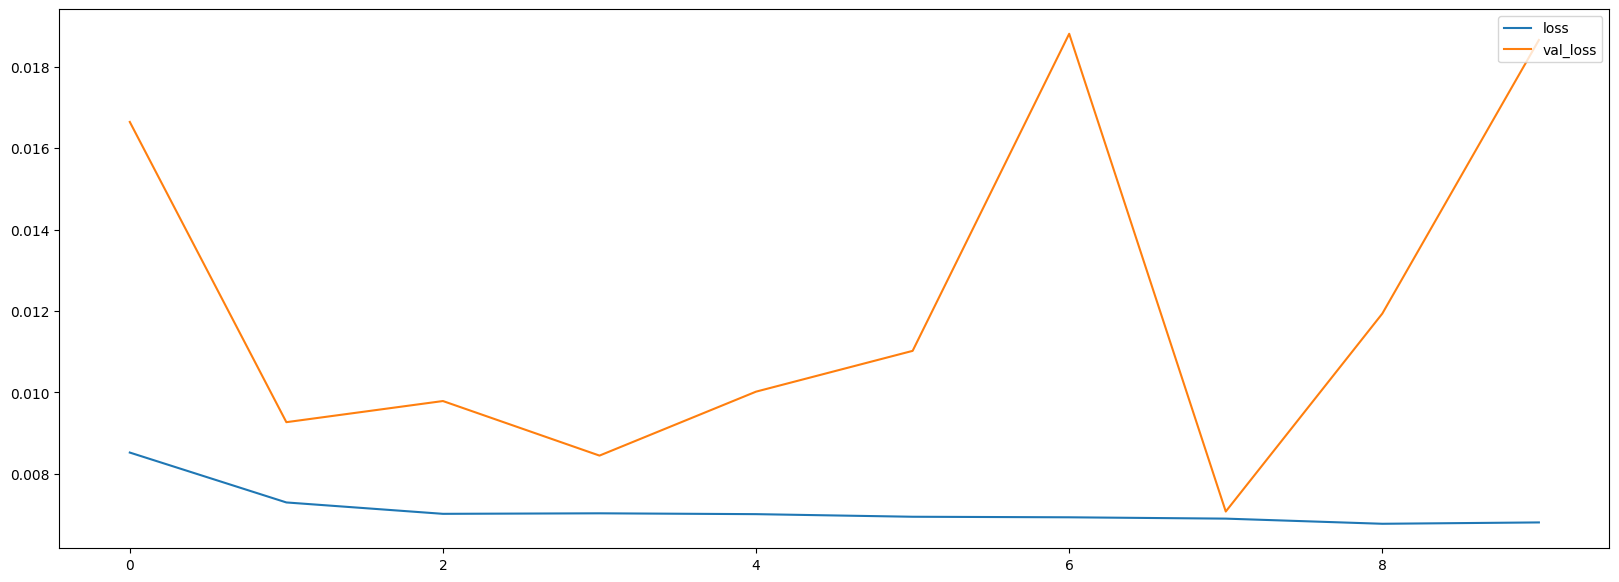

In [20]:
losses=trainer.history['losses']
val_losses=trainer.history['val_losses']
plt.figure(figsize=(20, 7))
plt.plot(range(len(losses)),losses)
plt.plot(range(len(val_losses)),val_losses)
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [21]:
"""trainer.model.module.base.train()
for i in range(5,12):
    for p in trainer.model.module.base.blocks[i].parameters():
        p.requires_grad=True
for p in trainer.model.module.base.norm.parameters():
    p.requires_grad=True

trainer.fit(train_loader=train_loader,
            val_loader=val_loader,
            epochs=5,
            verbose=1,
            patience=10)"""

'trainer.model.module.base.train()\nfor i in range(5,12):\n    for p in trainer.model.module.base.blocks[i].parameters():\n        p.requires_grad=True\nfor p in trainer.model.module.base.norm.parameters():\n    p.requires_grad=True\n\ntrainer.fit(train_loader=train_loader,\n            val_loader=val_loader,\n            epochs=5,\n            verbose=1,\n            patience=10)'

In [22]:
"""losses=trainer.history['losses']
val_losses=trainer.history['val_losses']
plt.figure(figsize=(20, 7))
plt.plot(range(len(losses)),losses)
plt.plot(range(len(val_losses)),val_losses)
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()"""

"losses=trainer.history['losses']\nval_losses=trainer.history['val_losses']\nplt.figure(figsize=(20, 7))\nplt.plot(range(len(losses)),losses)\nplt.plot(range(len(val_losses)),val_losses)\nplt.legend(['loss', 'val_loss'], loc='upper right')\nplt.show()"

In [23]:
torch.save(trainer.model.state_dict(),'/kaggle/working/model_weights.pth')

In [24]:
test_images='/kaggle/input/isic-2024-challenge/test-image.hdf5'
test=pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv',usecols=['isic_id'])
test.head()

,isic_id
0,ISIC_0015657
1,ISIC_0015729
2,ISIC_0015740


In [25]:
test_loader=loading_data(test['isic_id'].values,
                         test_images,
                         None,
                         batch_size,
                         False,
                         transform_val,
                         device)
preds=trainer.predict(test_loader)
submission=pd.read_csv('/kaggle/input/isic-2024-challenge/sample_submission.csv')
submission['target']=preds

In [26]:
submission.to_csv('/kaggle/working/submission.csv',index=False)